In [1]:
!nvidia-smi

Thu Sep 19 03:47:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   35C    P8               6W / 185W |     66MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
"""
Resnet-18 for classifying roof materials from PlanetScope SuperDove imagery
Case study in Denver, Colorado 
"""

import os, sys, time, glob
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms, utils
from torchsat.models.classification import resnet18

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from fiona.crs import from_epsg
from shapely.geometry import box
from os.path import join

import warnings
warnings.filterwarnings("ignore")

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32613)
print(f'Projected CRS: {proj}')

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

print("Successfully imported all packages!")

Projected CRS: EPSG:32613
Successfully imported all packages!


In [3]:
homedir = '/home/jovyan'

In [4]:
# Load the training data (footprints)
# gdf_path = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
gdf_path = join(homedir,'opp-data/denver_data_reference_footprints.gpkg')
ref = gpd.read_file(gdf_path)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,78TL,TL,Tile,271.028875,4710.0,"MULTIPOLYGON (((502162.154 4397355.647, 502162..."
1,269TL,TL,Tile,3885.053236,22307.0,"MULTIPOLYGON (((503091.622 4397021.987, 503101..."
2,490TL,TL,Tile,2018.268605,6250.0,"MULTIPOLYGON (((501990.912 4396754.28, 502007...."
3,497TL,TL,Tile,273.843801,6370.0,"MULTIPOLYGON (((502773.275 4396965.742, 502773..."
4,537TL,TL,Tile,281.649002,6000.0,"MULTIPOLYGON (((502162.107 4396885.437, 502168..."


In [5]:
# Observe the class imbalance
ref.class_code.value_counts()

class_code
CS    86561
WS    10642
AP     8117
TL     2843
CN     2757
SL      230
TG      228
Name: count, dtype: int64

In [6]:
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])
# Create a dictionary mapping class_code to code
code_mapping = dict(zip(ref['class_code'], ref['code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{'TL': 0, 'WS': 1, 'CN': 2, 'AP': 3, 'SL': 4, 'TG': 5, 'CS': 6}
Description map: 
{'TL': 'Tile', 'WS': 'Wood shake/shingle', 'CN': 'Concrete', 'AP': 'Asphalt', 'SL': 'Slate', 'TG': 'Tar and gravel', 'CS': 'Composition Shingle'}


In [7]:
# Perform balanced sampling (random undersampling)
ref_bal = balance_sampling(ref, ratio=20, strategy='undersample')
ref_bal.code.value_counts()

code
6    4560
1    4560
3    4560
0    2843
2    2757
4     230
5     228
Name: count, dtype: int64

In [8]:
# Split the train/test data
train_df, val_df, test_df = split_training_data(ref_bal, ts=0.4, vs=0.2)

# Print the class distribution in training and validation sets to verify stratification
print("Train class distribution:\n", train_df['code'].value_counts())
print("Validation class distribution:\n", val_df['code'].value_counts())
print("Test class distribution:\n", test_df['code'].value_counts())

Train class distribution:
 code
6    2736
1    2736
3    2736
0    1705
2    1654
4     138
5     136
Name: count, dtype: int64
Validation class distribution:
 code
6    1459
1    1459
3    1459
0     910
2     882
4      73
5      73
Name: count, dtype: int64
Test class distribution:
 code
6    365
1    365
3    365
0    228
2    221
4     19
5     19
Name: count, dtype: int64


In [10]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/denver_data/planet-data/denver_0815_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'opp-data/denver_0815_psscene8b_final_norm.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
n_bands = stack_da.values.shape[:1][0] # get a list of band names
print(
    f"shape: {stack_da.rio.shape}\n"
    f"bands: {n_bands}\n"
    f"resolution: {stack_da.rio.resolution()}\n"
    f"bounds: {stack_da.rio.bounds()}\n"
    f"sum: {stack_da.sum().item()}\n"
    f"CRS: {stack_da.rio.crs}\n"
    f"NoData: {stack_da.rio.nodata}\n"
    f"Array: {stack_da}"
)
del stack_da

shape: (14939, 6330)
bands: 6
resolution: (3.0, -3.0)
bounds: (489558.0, 4383960.0, 508548.0, 4428777.0)
sum: 15.8248291015625
CRS: EPSG:32613
NoData: None
Array: <xarray.DataArray (band: 6, y: 14939, x: 6330)> Size: 2GB
[567383220 values with dtype=float32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 51kB 4.896e+05 4.896e+05 ... 5.085e+05 5.085e+05
  * y            (y) float64 120kB 4.429e+06 4.429e+06 ... 4.384e+06 4.384e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5')


In [11]:
# Best params from tuning
params = {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.8, 'patience': 5}
print(f'Model params: {params}')

Model params: {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.8, 'patience': 5}


In [12]:
# Set up the Resnet-18 model

# Define whether to leverage cpu or gpu (for my local machine it is only cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
print(f'Using {device} for model dev ...')

# Grab the number of classes
n_classes = ref_bal.class_code.unique().shape[0]
print(f'There are {n_classes} roof type classes.')

# Define the Resnet-18 model (in_channels = number of bands in the image)
model = resnet18(n_classes, in_channels=n_bands, pretrained=False)

# Make model parallel and on GPU
if torch.cuda.device_count() >= 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)
else:
    model = nn.DataParallel(model)
    print('Made cpu parallel')

# optimizer, learning rate scheduler, loss criterion, scaler (gradient)
optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'], weight_decay=params['weight_decay'])
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=params['patience'], verbose=False, min_lr=1e-6)
scaler = torch.cuda.amp.GradScaler()  # initialize scaler for mixed precision

print('Ready to load data !')

Using cuda for model dev ...
There are 7 roof type classes.
Using  1 GPUs!
Ready to load data !


In [13]:
# Load the image data as a Dataset
# Uses the opimum window size calculated earlier

imdir = stack_da_fp
bs = params['batch_size']
window_size = params['window_size']

# Create the training samples
train_ds = RoofImageDatasetPlanet(train_df[['geometry', 'code']], imdir, n_bands=n_bands, img_dim=window_size)
train_loader = DataLoader(train_ds, batch_size=bs, num_workers=0, shuffle=True, pin_memory=True) 

# Create the validation samples
val_ds = RoofImageDatasetPlanet(val_df[['geometry', 'code']], imdir, n_bands=n_bands, img_dim=window_size)
val_loader = DataLoader(val_ds, batch_size=bs, num_workers=0, shuffle=False, pin_memory=True)

# Create the test samples
test_ds = RoofImageDatasetPlanet(test_df[['geometry', 'code']], imdir, n_bands=n_bands, img_dim=window_size)
test_loader = DataLoader(test_ds, batch_size=bs, num_workers=0, shuffle=False, pin_memory=True)

print("Training and validation data loaded!")

Training and validation data loaded!


In [14]:
# Number of samples in each class
val_counts = list(train_df['code'].value_counts())
total_samples = sum(val_counts) # total number of samples
print(f'Total samples: {total_samples};\nValue counts: {val_counts}')

# Calculate class weights
class_weights = [total_samples / count for count in val_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class weights: {class_weights}")

class_weights_norm = class_weights / class_weights.sum()
print(f"Normalized class weights: {class_weights_norm}")

# Updated loss function with weights
criterion = nn.CrossEntropyLoss(weight=class_weights_norm).to(device)

Total samples: 11841;
Value counts: [2736, 2736, 2736, 1705, 1654, 138, 136]
Class weights: tensor([ 4.3279,  4.3279,  4.3279,  6.9449,  7.1590, 85.8043, 87.0662],
       device='cuda:0')
Normalized class weights: tensor([0.0216, 0.0216, 0.0216, 0.0347, 0.0358, 0.4291, 0.4354],
       device='cuda:0')


In [15]:
gc.collect()

5012

In [16]:
t0 = time.time()

print_freq = int(len(train_loader) // 4) # quarterly print statements

# Initialize lists to track the losses for each epoch
train_losses = [] # stores epoch train losses
val_losses = [] # stores epoch validation losses
batch_train_losses = [] # all batch train losses
batch_val_losses = [] # all batch val losses

num_epochs = 22 # adjust as needed
for epoch in range(1, num_epochs):
    t00 = time.time() # epoch start time

    # The current learning rate:
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch}]. Current learning rate: {current_lr}")

    # Training loop
    model.train()

    epoch_train_losses = [] # to store the loss/batch
    
    for idx, batch in enumerate(train_loader):
        # Ensure a good batch
        batch = make_good_batch(batch)
        
        # Extract samples (image chunk, target label)
        image, target = batch['image'].to(device), batch['code'].to(device)

        optimizer.zero_grad() # reset the gradient

        # Use mixed precision
        with torch.cuda.amp.autocast():
            output = model(image.float())
            loss = criterion(output, target.long())
            
        scaler.scale(loss).backward()  # Mixed precision backward pass
        scaler.step(optimizer)  # Optimizer step
        scaler.update()

        # Print the train progress % and current loss
        if idx % print_freq == 0:
            print(f'\ttrain progress: [{idx * len(image)}/{len(train_loader.dataset)}] ({(100. * idx / len(train_loader)):.2f})%')
            print(f'\tbatch train loss: {loss.item():.4f};\tcumulative batch: {len(train_loader) * epoch + idx}')
        
        epoch_train_losses.append((idx, loss.item())) # append to epoch batch losses list
        batch_train_losses.append((idx, loss.item())) # track all batch losses

        del image, target, batch, output, loss
                
    # average loss for the epoch (across batches)
    train_loss = np.array(batch_train_losses)[:,1].mean()
    train_losses.append(train_loss)
    
    # validation loss
    model.eval()
    
    val_loss = 0
    correct = 0
    all_labs = []
    all_preds = []
    
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            # Ensure a good batch
            batch = make_good_batch(batch) 
            
            # Extract samples
            image, target = batch['image'].to(device), batch['code'].to(device)
            output = model(image.float())

            # Get validation loss and predictions
            val_loss += criterion(output, target).item()
            predicted = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += predicted.eq(target.view_as(predicted)).sum().item() # Number of correct
            
            # Store the labels
            all_labs.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            batch_val_losses.append(val_loss) # store the batch val losses (all)

            del image, target, batch, output
            
        val_loss /= len(val_loader.dataset)/val_loader.batch_size
        val_losses.append(val_loss)
    
    print(f"\nEpoch [{epoch}] completed.")
    print(f'\ttrain loss: {train_loss}; validation loss = {val_loss:.4f}')

    acc = 100. * correct / len(val_loader.dataset)
    f1 = f1_score(all_labs, all_preds, average="weighted")
    print(f'\tAccuracy (validation): [{correct}/{len(val_loader.dataset)}] ({acc:.4f})%;\n\tF1-score (validation): {f1:.4f}')

    # Adjust the learning rate based on the validation loss
    lr_scheduler.step(val_loss)
    if optimizer.param_groups[0]['lr'] != current_lr:
        print(f"! LR-Scheduler [ReduceLROnPlateau] adjustment: {optimizer.param_groups[0]['lr']} !")
     
    t1 = (time.time() - t00) / 60
    print(f"Time to complete epoch [{epoch}]: {t1:.2f} minutes.")
    print("\n~~~~~~~~~~\n")

    # # (optional) Implement early stopping based on 'patience'
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     counter = 0  # Reset counter if we see an improvement
    # else:
    #     counter += 1  # Increment counter if no improvement after learning rate adjustment
    #     if counter >= params['patience'] + 2:
    #         print(f"Early stopping after [{epoch}] epochs.")
    #         break
    
    gc.collect() # do a garbage cleanup
    torch.cuda.empty_cache()
    
t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

Epoch [1]. Current learning rate: 0.01
	train progress: [0/11841] (0.00)%
	batch train loss: 2.3270;	cumulative batch: 186
	train progress: [2944/11841] (24.73)%
	batch train loss: 0.7711;	cumulative batch: 232
	train progress: [5888/11841] (49.46)%
	batch train loss: 0.5410;	cumulative batch: 278
	train progress: [8832/11841] (74.19)%
	batch train loss: 0.8610;	cumulative batch: 324
	train progress: [11776/11841] (98.92)%
	batch train loss: 0.4615;	cumulative batch: 370

Epoch [1] completed.
	train loss: 0.7411021386743873; validation loss = 2.1601
	Accuracy (validation): [2179/6315] (34.5051)%;
	F1-score (validation): 0.2602
Time to complete epoch [1]: 4.46 minutes.

~~~~~~~~~~

Epoch [2]. Current learning rate: 0.01
	train progress: [0/11841] (0.00)%
	batch train loss: 0.6534;	cumulative batch: 372
	train progress: [2944/11841] (24.73)%
	batch train loss: 0.4240;	cumulative batch: 418
	train progress: [5888/11841] (49.46)%
	batch train loss: 0.2898;	cumulative batch: 464
	train prog

In [42]:
results_dir = os.path.join(homedir,'results/')

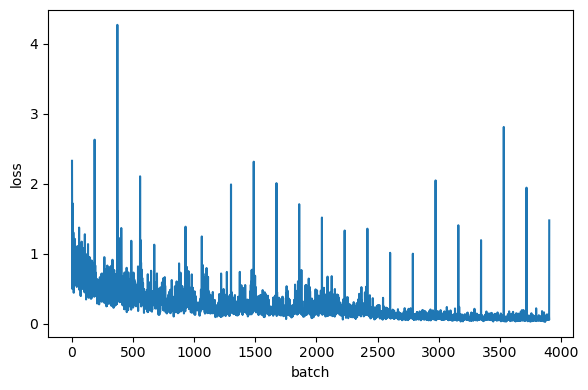

In [83]:
# Plot the batch losses
plt.figure(figsize=(6, 4))

plt.plot(np.array(batch_train_losses)[:,1])

plt.xlabel('batch')
plt.ylabel('loss')
plt.tight_layout()

out_png = os.path.join(homedir,'results/denver_batch_train_loss.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

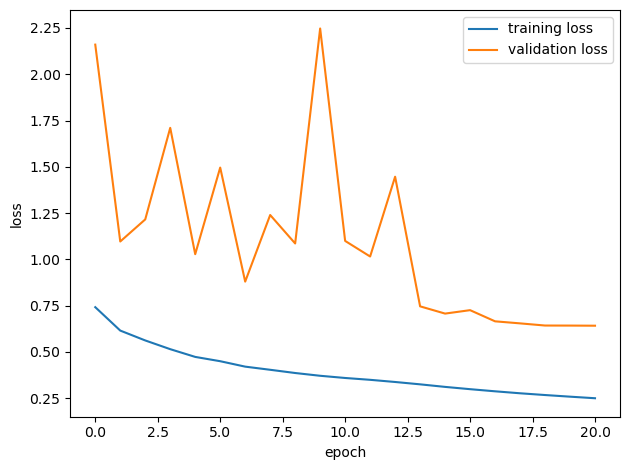

In [84]:
# Epoch training loss
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.tight_layout()
plt.legend()

out_png = os.path.join(homedir,'results/denver_epoch_trainval_loss.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Check model complexity

In [70]:
train_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of traininable model parameters: {train_model_params}")

Number of traininable model parameters: 11189511


In [ ]:
# Save the model elements

In [21]:
os.getcwd()

'/home/jovyan/opp-rooftop-mapping/code'

In [85]:
# Save the model

save_res = True

if save_res:
    # directory
    save_dir = os.path.join(homedir,'results/')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    step = len(train_losses)
    model_nm = f'ep{num_epochs}_step{step}_b{bs}'
    model_path = 'denver_planet_ms_ep{}_step{}_b{}.pt'.format(num_epochs, step, bs)
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'step': step,
        }, str(model_path))
    save(model_path)

    # save loss, etc

    # batch loss
    np.savetxt(os.path.join(save_dir,f'denver_batch_train_losses_{model_nm}.txt'), np.array(batch_train_losses))
    np.savetxt(os.path.join(save_dir,f'denver_batch_val_losses_{model_nm}.txt'), np.array(batch_val_losses))
    
    # epoch loss
    np.savetxt(os.path.join(save_dir,f'denver_train_losses_{model_nm}.txt'), np.array(train_losses))
    np.savetxt(os.path.join(save_dir,f'denver_val_losses_{model_nm}.txt'), np.array(val_losses))
print("Saved model and losses.")

Saved model and losses.


In [ ]:
# Make predictions on the holdout data

In [27]:
def get_prediction(m, s):
    s = s.to(device)  # Ensure the sample is moved to the correct device
    res = m(s)
    return res

true_labels = []
pred_labels = []

model.eval()  # Set model to evaluation mode

for idx, sample in enumerate(test_ds):
    try:
        if sample['code'] != 255:
            # Append true labels
            true_labels.append(sample['code'].item())  # Convert tensor to Python scalar
                        
            # Get prediction and append
            pred = get_prediction(model, sample['image'][None, ...].float().to(device))  # Ensure tensor is float and on the correct device
            pred_labels.append(pred.argmax().item())  # Convert tensor to Python scalar
            
        else:
            print(f'sample {idx} of {len(test_ds)} had class label 255, skipping...')
        
        if idx % 100 == 0:
            time.sleep(0.3)
            gc.collect()
            print(f'Processed {idx} samples...')
        
    except Exception as e:
        print(f'Error at sample {idx}: {e}, continuing...')

Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...


In [46]:
# Ensure 'class_code' is of categorical dtype
test_df['code'] = test_df['code'].astype('category')
# Create a dictionary mapping class_code to code
code_mapping = dict(zip(test_df['code'], test_df['class_code']))
desc_mapping = dict(zip(test_df['class_code'], test_df['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{6: 'CS', 1: 'WS', 3: 'AP', 0: 'TL', 2: 'CN', 4: 'SL', 5: 'TG'}
Description map: 
{'CS': 'Composition Shingle', 'WS': 'Wood shake/shingle', 'AP': 'Asphalt', 'TL': 'Tile', 'CN': 'Concrete', 'SL': 'Slate', 'TG': 'Tar and gravel'}


In [73]:
# Save to a dataframe
preds_df = pd.DataFrame({
    'true_code': true_labels,
    'pred_code': pred_labels
})

# Add a column for the true class_code using the code_mapping dictionary
preds_df['true_class'] = preds_df['true_code'].map(code_mapping)
preds_df['pred_class'] = preds_df['pred_code'].map(code_mapping)

# Save the DataFrame as a CSV file if needed
preds_df.to_csv(os.path.join(homedir,'results/denver_predictions_holdout.csv'), index=False)

In [62]:
true_class_labels = [code_mapping[code] for code in true_labels]
pred_class_labels = [code_mapping[code] for code in pred_labels]
class_codes = list(code_mapping.values())

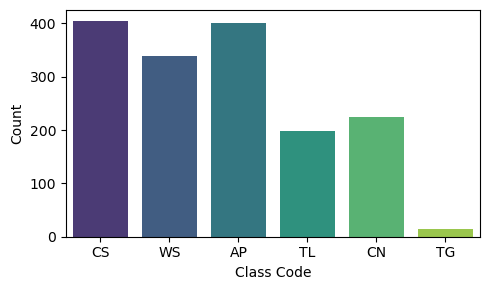

In [68]:
pred_class_labels = [code_mapping[code] for code in pred_labels]

plt.figure(figsize=(5, 3))
sns.countplot(x=pred_class_labels, palette='viridis')
plt.xlabel('Class Code')
plt.ylabel('Count')
plt.tight_layout()

out_png = os.path.join(homedir,'results/denver_cnn_pred_labels.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Generate the classification report

In [63]:
# Generate the classification report
cr_df = pd.DataFrame(classification_report(
    true_class_labels, pred_class_labels, 
    target_names=class_codes, 
    output_dict=True)).transpose()
cr_df['class_code'] = cr_df.index
# Save the report as a CSV
cr_df.to_csv(os.path.join(save_dir, 'denver_resnet18_classification_report.csv'))
print(cr_df)

              precision    recall  f1-score      support    class_code
CS             0.850374  0.934247  0.890339   365.000000            CS
WS             0.848214  0.859729  0.853933   221.000000            WS
AP             0.800000  0.887671  0.841558   365.000000            AP
TL             0.000000  0.000000  0.000000    19.000000            TL
CN             0.600000  0.473684  0.529412    19.000000            CN
SL             0.868687  0.754386  0.807512   228.000000            SL
TG             0.764012  0.709589  0.735795   365.000000            TG
accuracy       0.818584  0.818584  0.818584     0.818584      accuracy
macro avg      0.675898  0.659901  0.665507  1582.000000     macro avg
weighted avg   0.807944  0.818584  0.811377  1582.000000  weighted avg


In [ ]:
# Generate the confusion matrix

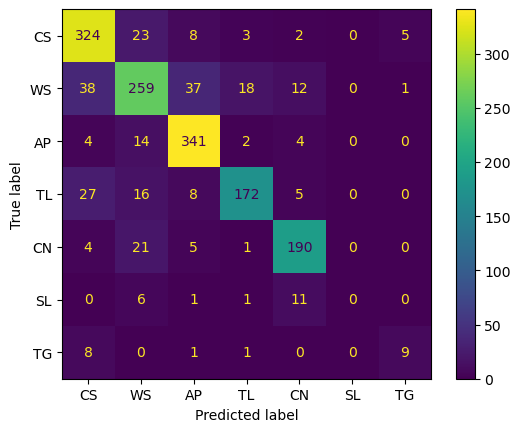

In [60]:
# Get the correct class names
class_names = list(code_mapping.values())
  
# Plot the confusion matrix
cm = confusion_matrix(true_class_labels, pred_class_labels, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
# Save it
out_png = os.path.join(homedir,'results/denver_cnn_confusion_matrix.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')  